# **Convolutional Neural Network**

In this lesson we will cover Neural Networks using the Sequential model. We will also build sequential models and Convolutional Neural Networks commonly used for image classification. First we will build an image classifier using dense layers only, then we will enhace the model by adding convolutional layers. Later we will use a pre-trained model and also tune the model.This lesson was taken from the book [Deep Learning with Python](https://learning.oreilly.com/library/view/deep-learning-with/9781617294433/OEBPS/Text/05.xhtml).

In [1]:
import numpy as np
import os

# model
import tensorflow as tf
from keras.models import Sequential

# layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten

# pretarined model
from keras.applications import VGG16

# kekeras.applicationss
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import TensorBoard


# visual stuffs
import matplotlib.pyplot as plt

2023-10-31 19:22:04.980915: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/carlos/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%%html
<img src='./images/Pixels.png', width=900, height=900>

[Image Source](https://learning.oreilly.com/library/view/python-machine-learning/9781787125933/ch15.html)

## Images

For the entire lesson we used the [Cats and Dogs](https://www.kaggle.com/c/dogs-vs-cats/data) dataset from Kaggle.

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation d

In [4]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


Found 2000 images belonging to 2 classes.


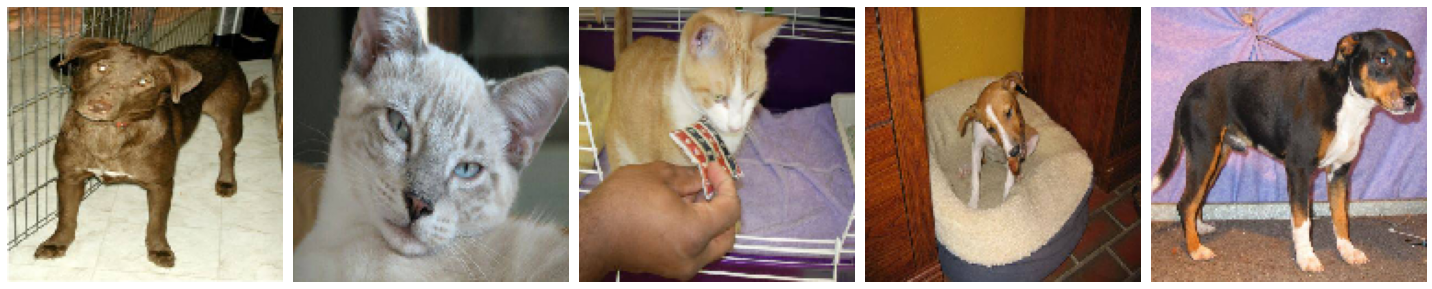

In [5]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data

train_data_gen = train_image_generator.flow_from_directory(batch_size=20,
                                                           directory=train_dir,
                                                           classes=['dogs', 'cats'],
                                                           shuffle=True,
                                                           target_size=(150, 150),
                                                           class_mode='binary')


sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(sample_training_images[:5])

## Image Classification with Dense Layers

As you may already know the neurons in a dense layer are not connected but are interconected with all neurons in prior and sud-sequent layers. Before proceeding into more detail I should first explain what python generators are why use generators to train neural networks.

In [6]:
%%html
<img src='../Week6_4.23/Multi_NN.png', width=700, height=700>

### Python Generators

In [7]:
def make_list(nums):
    
    my_list = [num for num in range(nums)]
    
    return my_list
    

In [8]:
my_list = make_list(5)

In [9]:
my_list

[0, 1, 2, 3, 4]

In [10]:
for i in my_list:
    print(i)

0
1
2
3
4


In [11]:
def make_generator(nums):
    
    for num in range(nums):
        yield num

In [12]:
make_gen = make_generator(5)

In [13]:
make_gen

<generator object make_generator at 0x7ff6b11ce7b0>

In [14]:
for i in make_gen:
    print(i)

0
1
2
3
4


In [15]:
for i in make_gen:
    print(i)

In [16]:
make_gen = make_generator(10)

In [17]:
for i in make_gen:
    print(i)

0
1
2
3
4
5
6
7
8
9


In [18]:
for i in make_gen:
    print(i)

### Preparing the Data

In [19]:
train_gen = ImageDataGenerator(rescale=1/255)
test_gen = ImageDataGenerator(rescale=1/255)

In [20]:
train_generator = train_gen.flow_from_directory(
                    train_dir, 
                    target_size=(150, 150), 
                    batch_size=20,
                    classes=['dogs', 'cats'],
                    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [21]:
valid_generator = test_gen.flow_from_directory(
                    validation_dir, 
                    target_size=(150, 150), 
                    batch_size=20,
                    classes=['dogs', 'cats'],
                    class_mode='binary')

Found 1000 images belonging to 2 classes.


### Dense Layers Model

In [22]:
model_seq = Sequential()

model_seq.add(Dense(200, input_shape=(150, 150, 3), activation='relu'))
model_seq.add(Dense(200, activation='relu'))
model_seq.add(Flatten())
model_seq.add(Dense(1, activation='sigmoid'))

model_seq.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [23]:
150*150*200

4500000

In [24]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150, 150, 200)     800       
                                                                 
 dense_1 (Dense)             (None, 150, 150, 200)     40200     
                                                                 
 flatten (Flatten)           (None, 4500000)           0         
                                                                 
 dense_2 (Dense)             (None, 1)                 4500001   
                                                                 
Total params: 4541001 (17.32 MB)
Trainable params: 4541001 (17.32 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
model_seq.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=10, 
    validation_data=valid_generator, 
    validation_batch_size=10,
)

Epoch 1/10
10/10 [==============================] - 29s 3s/step - loss: 1.8660 - acc: 0.5600 - val_loss: 0.6964 - val_acc: 0.5350
Epoch 2/10
10/10 [==============================] - 58s 6s/step - loss: 0.6972 - acc: 0.4900 - val_loss: 0.6865 - val_acc: 0.5380
Epoch 3/10
10/10 [==============================] - 37s 4s/step - loss: 0.6821 - acc: 0.5650 - val_loss: 0.6818 - val_acc: 0.5490
Epoch 4/10
10/10 [==============================] - 31s 3s/step - loss: 0.6733 - acc: 0.5750 - val_loss: 0.6803 - val_acc: 0.5570
Epoch 5/10
10/10 [==============================] - 45s 5s/step - loss: 0.6862 - acc: 0.5800 - val_loss: 0.6725 - val_acc: 0.5740
Epoch 6/10
10/10 [==============================] - 38s 4s/step - loss: 0.6752 - acc: 0.5800 - val_loss: 0.6696 - val_acc: 0.5930
Epoch 7/10
10/10 [==============================] - 35s 4s/step - loss: 0.6592 - acc: 0.6300 - val_loss: 0.6717 - val_acc: 0.5700
Epoch 8/10
10/10 [==============================] - 36s 4s/step - loss: 0.6796 - acc: 0.58

## Convolutional Neural Network (CNN)

Convolutional layers can be considered as filters that extract the important features from an image. Compared to dense layers, convolutional layers share the weights within a single layer. Convolutional layers work by first taking small patches then taking dot product of the patch and a kernel filter. After each convolution the heigh and width of the image will shrink while the numbers of channels will increase. A simple explanation of how CNN work can be found [here](https://www.youtube.com/watch?v=x_VrgWTKkiM). More detailed explanation are found [here](https://learning.oreilly.com/videos/understanding-convolutional-neural/9781491978931/9781491978931-video312598).

In [26]:
%%html
<img src='./images/CNN.png', width=500, height=500>

In [27]:
%%html
<img src='./images/Pooling.png', width=700, height=700>

[Image Source](https://learning.oreilly.com/library/view/python-machine-learning/9781787125933/ch15.html)

In [27]:
%%html
<img src='./images/CNNFC.png', width=1000, height=1000>

[Image Source](https://www.kdnuggets.com/2016/11/intuitive-explanation-convolutional-neural-networks.html/3)

In [28]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPool2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(200, activation='relu'))
model_cnn.add(Dense(200, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [29]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)      

In [30]:
model_cnn.fit(
    train_generator, 
    steps_per_epoch=10,  
    epochs=10, 
    validation_data=valid_generator, 
    validation_batch_size=10,
    workers=8
)

Epoch 1/10
10/10 [==============================] - 7s 606ms/step - loss: 0.6924 - acc: 0.5200 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 2/10
10/10 [==============================] - 6s 604ms/step - loss: 0.6931 - acc: 0.4900 - val_loss: 0.6907 - val_acc: 0.5840
Epoch 3/10
10/10 [==============================] - 6s 662ms/step - loss: 0.6931 - acc: 0.4800 - val_loss: 0.6927 - val_acc: 0.5010
Epoch 4/10
10/10 [==============================] - 7s 736ms/step - loss: 0.6937 - acc: 0.4600 - val_loss: 0.6899 - val_acc: 0.5150
Epoch 5/10
10/10 [==============================] - 8s 872ms/step - loss: 0.6928 - acc: 0.4900 - val_loss: 0.6894 - val_acc: 0.5880
Epoch 6/10
10/10 [==============================] - 10s 994ms/step - loss: 0.6926 - acc: 0.5200 - val_loss: 0.6901 - val_acc: 0.5000
Epoch 7/10
10/10 [==============================] - 10s 1s/step - loss: 0.6869 - acc: 0.5250 - val_loss: 0.6885 - val_acc: 0.5490
Epoch 8/10
10/10 [==============================] - 12s 1s/step - loss: 0.690

## CNN with Data Augmentation

In [35]:
%%html
<img src='./images/Dog_augmented.png', width=900, height=900>

In [31]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

In [32]:
train_generator = train_datagen.flow_from_directory(
        train_dir,                                          
        target_size=(150, 150),                             
        batch_size=32,
        shuffle=True,
        class_mode='binary'
) 

Found 2000 images belonging to 2 classes.


In [33]:
model_cnn_aug = Sequential()

model_cnn_aug.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'))
model_cnn_aug.add(MaxPool2D((2, 2)))
model_cnn_aug.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn_aug.add(MaxPool2D((2, 2)))
model_cnn_aug.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn_aug.add(MaxPool2D((2, 2)))
model_cnn_aug.add(Flatten())
model_cnn_aug.add(Dense(200, activation='relu'))
model_cnn_aug.add(Dense(200, activation='relu'))
model_cnn_aug.add(Dense(1, activation='sigmoid'))

model_cnn_aug.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [35]:
model_cnn_aug.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=10, 
    validation_data=valid_generator, 
    validation_batch_size=10,
    workers=42,
)

Epoch 1/10
10/10 [==============================] - 10s 911ms/step - loss: 0.6928 - acc: 0.5296 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 2/10
10/10 [==============================] - 10s 923ms/step - loss: 0.6943 - acc: 0.5156 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 3/10
10/10 [==============================] - 15s 1s/step - loss: 0.6930 - acc: 0.5219 - val_loss: 0.6946 - val_acc: 0.4610
Epoch 4/10
10/10 [==============================] - 12s 1s/step - loss: 0.6945 - acc: 0.5312 - val_loss: 0.6948 - val_acc: 0.4680
Epoch 5/10
10/10 [==============================] - 14s 1s/step - loss: 0.6935 - acc: 0.5000 - val_loss: 0.6954 - val_acc: 0.4350
Epoch 6/10
10/10 [==============================] - 15s 1s/step - loss: 0.6910 - acc: 0.5250 - val_loss: 0.6981 - val_acc: 0.4950
Epoch 7/10
10/10 [==============================] - 15s 1s/step - loss: 0.6939 - acc: 0.5156 - val_loss: 0.6968 - val_acc: 0.4670
Epoch 8/10
10/10 [==============================] - 13s 1s/step - loss: 0.6932 - acc

## Fine Tunning a pre-Trained Model-VGG16

For small datasets we can use a pre-trained machine learning model and attach a fully connected dense layers at the top to enhance the task. Keras does provide with a set of pre-trained models, [Keras pre-trained CNN](https://keras.io/applications/). For this lesson we will use VGG 16 model.


In [39]:
vgg = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3))

In [40]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [41]:
vgg.trainable = True

for layer in vgg.layers:
    if layer.name == 'block5_conv1':
        layer.trainable = True
    else:
        layer.trainable = False

In [42]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [43]:
model_vgg = Sequential()

model_vgg.add(vgg)
model_vgg.add(Flatten())
model_vgg.add(Dense(200, activation='relu'))
model_vgg.add(Dense(200, activation='relu'))
model_vgg.add(Dense(1, activation='sigmoid'))

model_vgg.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])

In [44]:
model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 200)               1638600   
                                                                 
 dense_10 (Dense)            (None, 200)               40200     
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 16393689 (62.54 MB)
Trainable params: 4038809 (15.41 MB)
Non-trainable params: 12354880 (47.13 MB)
_________________________________________________________________


In [45]:
tensorboard = TensorBoard(
  log_dir='./logs',
  histogram_freq=1,
  write_images=True
)

In [46]:
model_vgg.fit(
    train_generator, 
    steps_per_epoch=10, 
    epochs=10,
    validation_data=valid_generator, 
    callbacks=[tensorboard]
)

Epoch 1/10
10/10 [==============================] - 113s 12s/step - loss: 0.7058 - acc: 0.5437 - val_loss: 0.7951 - val_acc: 0.3040
Epoch 2/10
10/10 [==============================] - 124s 13s/step - loss: 0.6793 - acc: 0.6031 - val_loss: 0.8767 - val_acc: 0.4000
Epoch 3/10
10/10 [==============================] - 95s 10s/step - loss: 0.6844 - acc: 0.5750 - val_loss: 0.9562 - val_acc: 0.4660
Epoch 4/10
10/10 [==============================] - 104s 11s/step - loss: 0.5953 - acc: 0.7000 - val_loss: 1.1856 - val_acc: 0.4430
Epoch 5/10
10/10 [==============================] - 103s 11s/step - loss: 0.5956 - acc: 0.6781 - val_loss: 1.0987 - val_acc: 0.1820
Epoch 6/10
10/10 [==============================] - 117s 13s/step - loss: 0.4802 - acc: 0.8313 - val_loss: 1.4505 - val_acc: 0.1920
Epoch 7/10
10/10 [==============================] - 118s 13s/step - loss: 0.5571 - acc: 0.7437 - val_loss: 1.5216 - val_acc: 0.2820
Epoch 8/10
10/10 [==============================] - 109s 12s/step - loss: 0.6

In [47]:
model_vgg.evaluate(train_generator)

63/63 [==============================] - 153s 2s/step - loss: 0.4317 - acc: 0.8000


[0.43167778849601746, 0.800000011920929]

In [48]:
train_predictions = model_vgg.predict(train_generator)

63/63 [==============================] - 205s 3s/step


In [49]:
train_predictions

array([[0.11976423],
       [0.44708028],
       [0.3970015 ],
       ...,
       [0.3084351 ],
       [0.35415643],
       [0.07288311]], dtype=float32)

In [50]:
model_vgg.evaluate(valid_generator)

50/50 [==============================] - 89s 2s/step - loss: 1.8748 - acc: 0.1500


[1.8748486042022705, 0.15000000596046448]

In [53]:
%reload_ext tensorboard
%tensorboard -- logdirs='./logs'

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-10-31 20:26:06.566338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/carlos/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
         

## Fine tunning VGG16 in Kaggle Kernel, [here](https://www.kaggle.com/carlosezmez/cnn-cuny-tech-prep/edit)